In [1]:
%pip install deepface
%pip install tensorflow
%pip install matplotlib
%pip install opencv-contrib-python

Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


In [2]:
import tensorflow as tf
import cv2
import matplotlib.pyplot as plt
import numpy as np
import zipfile
import os

2023-12-06 23:41:13.626290: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-12-06 23:41:14.323278: I external/local_tsl/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.
2023-12-06 23:41:15.971363: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2023-12-06 23:41:15.971626: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2023-12-06 23:41:16.193230: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to

In [3]:
img_file = cv2.imread("data/train/0/Training_10120469.jpg")

In [4]:
img_file.shape

(48, 48, 3)

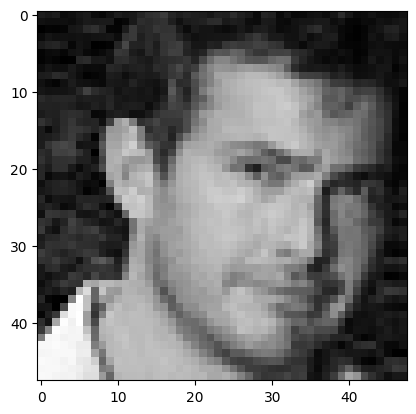

In [5]:
plt.imshow(img_file)

In [6]:
train_dataset_directory = "train"

In [7]:
classes = ["0", "1", "2", "3", "4", "5", "6"]

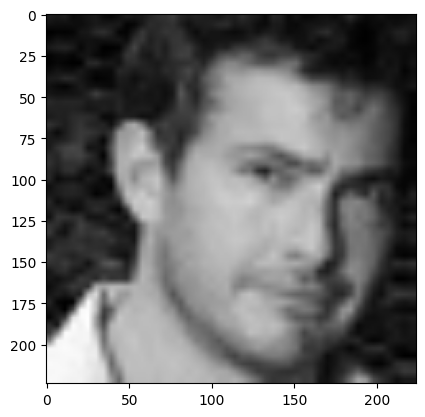

In [8]:
img_size = 224 # 224x224
new_array = cv2.resize(img_file, (img_size, img_size))
plt.imshow(new_array)

In [9]:
new_array.shape

(224, 224, 3)

### Read all images and convert them to array

In [10]:
training_data = []

def create_training_data():
    for category in classes:
        path = os.path.join("data", train_dataset_directory, category)
        class_num = classes.index(category)
        for img in os.listdir(path)[:100]:
            try:
                img_array = cv2.imread(os.path.join(path, img))
                new_array = cv2.resize(img_array, (img_size, img_size))
                training_data.append([new_array, class_num])
            except Exception as e:
                pass

In [11]:
create_training_data()

In [12]:
print(len(training_data))

700


In [13]:
import random

random.shuffle(training_data)

In [14]:
X = [] # features
y = [] # label

for features, label in training_data:
    X.append(features)
    y.append(label)

X = np.array(X).reshape(-1, img_size, img_size, 3) # Converting to 4 dimensional array

In [15]:
X.shape

(700, 224, 224, 3)

In [16]:
X[0]

array([[[35, 35, 35],
        [35, 35, 35],
        [35, 35, 35],
        ...,
        [15, 15, 15],
        [15, 15, 15],
        [15, 15, 15]],

       [[35, 35, 35],
        [35, 35, 35],
        [35, 35, 35],
        ...,
        [16, 16, 16],
        [15, 15, 15],
        [15, 15, 15]],

       [[35, 35, 35],
        [35, 35, 35],
        [35, 35, 35],
        ...,
        [16, 16, 16],
        [15, 15, 15],
        [15, 15, 15]],

       ...,

       [[28, 28, 28],
        [28, 28, 28],
        [28, 28, 28],
        ...,
        [ 2,  2,  2],
        [ 1,  1,  1],
        [ 1,  1,  1]],

       [[28, 28, 28],
        [28, 28, 28],
        [28, 28, 28],
        ...,
        [ 2,  2,  2],
        [ 1,  1,  1],
        [ 1,  1,  1]],

       [[28, 28, 28],
        [28, 28, 28],
        [28, 28, 28],
        ...,
        [ 1,  1,  1],
        [ 1,  1,  1],
        [ 1,  1,  1]]], dtype=uint8)

In [17]:
# Normalizing the data
X = X/255.0

In [18]:
y[100]

3

### Deep Learning model for training - Transfer Learning

In [19]:
from tensorflow import keras
from tensorflow.keras import layers

In [20]:
model = tf.keras.applications.MobileNetV2() ## Pre-trained model

14536120/14536120 [==============================] - 26s 2us/step


In [21]:
model.summary()

Model: "mobilenetv2_1.00_224"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 224, 224, 3)]        0         []                            
                                                                                                  
 Conv1 (Conv2D)              (None, 112, 112, 32)         864       ['input_1[0][0]']             
                                                                                                  
 bn_Conv1 (BatchNormalizati  (None, 112, 112, 32)         128       ['Conv1[0][0]']               
 on)                                                                                              
                                                                                                  
 Conv1_relu (ReLU)           (None, 112, 112, 32)         0         ['bn_Conv1[

# Transfer Learning - Tuning
* Weights will start from last checkpoint.

In [22]:
base_input = model.layers[0].input

In [23]:
# setting the last checkpoint to the before last layer
base_output = model.layers[-2].output

In [24]:
base_output

<KerasTensor: shape=(None, 1280) dtype=float32 (created by layer 'global_average_pooling2d')>

In [25]:
# Adding layers to the checkpoint
final_output = layers.Dense(128)(base_output)
final_output = layers.Activation('relu')(final_output)
final_output = layers.Dense(64)(final_output)
final_output = layers.Activation('relu')(final_output)
final_output = layers.Dense(7, activation='softmax')(final_output) # 7 Classes, This is classification layernew

In [26]:
final_output

<KerasTensor: shape=(None, 7) dtype=float32 (created by layer 'dense_2')>

In [27]:
# Creating the model
new_model = keras.Model( inputs= base_input, outputs=final_output)

In [28]:
new_model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 224, 224, 3)]        0         []                            
                                                                                                  
 Conv1 (Conv2D)              (None, 112, 112, 32)         864       ['input_1[0][0]']             
                                                                                                  
 bn_Conv1 (BatchNormalizati  (None, 112, 112, 32)         128       ['Conv1[0][0]']               
 on)                                                                                              
                                                                                                  
 Conv1_relu (ReLU)           (None, 112, 112, 32)         0         ['bn_Conv1[0][0]']        

In [29]:
new_model.compile(loss="sparse_categorical_crossentropy", optimizer="adam", metrics=["accuracy"])

In [30]:
Y = np.array(y)

In [31]:
Y.shape

(700,)

In [32]:
new_model.fit(X, Y, epochs=25)

Epoch 1/25
22/22 [==============================] - 38s 1s/step - loss: 1.9020 - accuracy: 0.2329
Epoch 2/25
22/22 [==============================] - 29s 1s/step - loss: 1.4553 - accuracy: 0.4814
Epoch 3/25
22/22 [==============================] - 31s 1s/step - loss: 0.9603 - accuracy: 0.6586
Epoch 4/25
22/22 [==============================] - 30s 1s/step - loss: 0.8068 - accuracy: 0.7257
Epoch 5/25
21/22 [===========================>..] - ETA: 1s - loss: 0.8159 - accuracy: 0.7188

KeyboardInterrupt: 